# <span style="font-size: 28px;"><b>Building Validation and Application of an Advanced Model</b></span>

## **Step 1: Set Up Environment and Connect to SQL Server**

In [ ]:
pip install pyodbc sqlalchemy pandas scikit-learn matplotlib seaborn

In [ ]:
import pyodbc

server = 'SQLEXPRESS'
database = 'Transactions'
driver= '{SQL Server}'
trusted= 'yes'

# Connection string
conn_str = f'DRIVER={driver};SERVER={server};DATABASE={database};Trusted_Connection={trusted}'

# Connect to the database
conn = pyodbc.connect(conn_str)
cursor = conn.cursor()

## **Step 2: Load Data**

In [ ]:
import pandas as pd

query = '''
SELECT transaction_id, customer_id, 
       CAST(date AS DATE) as date, 
       CAST(time AS TIME) as time, 
       product_name, category, quantity, price
FROM [Transactions].[dbo].[Transactions]
'''

df = pd.read_sql_query(query, conn)

## **Step 3: Preprocess the Data**

In [29]:
# Convert date and time into datetime and extract useful features
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df['day_of_week'] = df['datetime'].dt.dayofweek
df['hour'] = df['datetime'].dt.hour

# Now drop the original date, time, and datetime columns as they are no longer needed directly
X = df.drop(['transaction_id', 'price', 'date', 'time', 'datetime'], axis=1)
y = df['price']

# Update categorical_features to include or exclude newly created features based on your preference
categorical_features = ['customer_id', 'product_name', 'category', 'day_of_week']
# Assuming hour might be treated as a categorical feature for simplicity; convert it if needed
X['hour'] = X['hour'].astype(str)

# Preprocessing for categorical variables
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough')

## **Step 4: Define and Train the Model**

In [ ]:
# Define the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=44))
])

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

# Train the model
model.fit(X_train, y_train)

## **Step 5: Make Predictions and Evaluate the Model**

In [31]:
# Make predictions and evaluate the model
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 6296.607285747054


## **Step 6: Visualization of Model Performance**

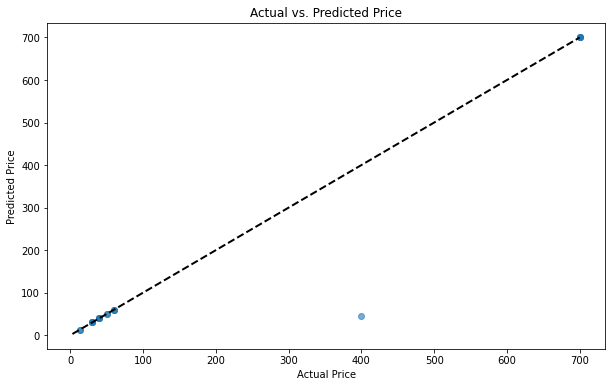

In [32]:
# Visualization of actual vs. predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted Price')
plt.show()

## **Step 7: Display Predictions**

In [33]:
# Sales predictions
print("Sales Predictions:")
for i in range(5):
    print(f"Sample {i+1}: Actual Price: {y_test.iloc[i]}, Predicted Price: {predictions[i]:.2f}")

Sales Predictions:
Sample 1: Actual Price: 39.9900016784668, Predicted Price: 39.99
Sample 2: Actual Price: 39.9900016784668, Predicted Price: 39.99
Sample 3: Actual Price: 699.989990234375, Predicted Price: 699.98
Sample 4: Actual Price: 29.989999771118164, Predicted Price: 29.99
Sample 5: Actual Price: 39.9900016784668, Predicted Price: 39.99
